during the ETLT
1. combine both motorist and sgcarmart
2. names to be extracted -> brand and model 
3. fetch data from API
4. combine both APIs together to get 1 dataset
5. derive the vehicle classes
6. fetch the COE prices

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from google.cloud import bigquery
pd.set_option('display.max_columns', None)

In [78]:
# read dataset first
# data = pd.read_csv('../Datasets/final_combined_dataset.csv')

path_to_private_key = 'is3107-418903-a6116d294003.json'
bigquery_client = bigquery.Client.from_service_account_json(json_credentials_path=path_to_private_key)

sql = """
        SELECT * FROM `is3107-418903.final.carsCombinedFinal`
        """
data = bigquery_client.query(sql).to_dataframe()

In [79]:
data = data.dropna()

In [80]:
data

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,accessories,model_make_id,make,model_trim,model_year,model_body,model_seats,model_weight_kg,model_engine_fuel,model_engine_cyl,model_drive,model_transmission_type,model_fuel_cap_l,vehicle_class,coe_bidding_no,coe_premium,coe_month,date_listed
0,1,2981.0,468000.0,72740.0,41000.0,272.0,5.01,130138.0,206249.0,Agent unit with extended warranty till 2027. C...,338,porsche,11526,2019,Coupe,4,1429.931973,premium unleaded (required),flat 6,rear wheel drive,7-speed manual,63.9665,Category B,2,102001,2024-04,2024-04-22 00:00:00.000000
2,4,3387.0,119800.0,33230.0,100000.0,217.0,3.60,86438.0,86438.0,"COE Car, Premium Ad Car, Low Mileage Car",581,porsche,39848,2008,Coupe,2,1299.773243,Gasoline,6,Rear,Manual,63.9665,Category B,2,102001,2024-04,2024-04-22 00:00:00.000000
5,5,3999.0,148888.0,23410.0,162000.0,308.0,6.36,82408.0,82408.0,"Navigation, Harman Kardon sound system, adapti...",bmw,bmw,Convertible,2010,Convertible,5,1885.000000,Gasoline - Premium,8,Rear,6-speed manual,63.0000,Category B,2,102001,2024-04,2024-04-22 00:00:00.000000
7,6,4308.0,268000.0,65260.0,54100.0,357.0,4.02,161895.0,161895.0,"New clutch (2022), cream interior leather, PPF...",772,ferrari,38501,2008,Coupe,2,1449.433107,Gasoline - Premium,8,Rear,Automatic,95.0035,Category B,2,102001,2024-04,2024-04-23 00:00:00.000000
9,1,2199.0,117000.0,18070.0,80180.0,147.0,5.39,33709.0,39193.0,All vehicles have gone through a rigorous 160 ...,261,kia,10833,2019,SUV,7,1799.546485,regular unleaded,V6,front wheel drive,8-speed shiftable automatic,71.1580,Category B,2,102001,2024-04,2024-04-22 00:00:00.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,1,3993.0,338800.0,142120.0,73500.0,372.8,0.17,206404.0,343528.0,"Mulliner specification, 21"" rims, original 2 t...",553,bentley,21241,2015,Convertible,4,2494.331066,flex-fuel (premium unleaded required/E85),W12,all wheel drive,8-speed shiftable automatic,90.8400,Category B,1,96010,2024-03,2024-03-17 00:00:00.000000
9020,3,4196.0,63000.0,22660.0,59812.0,218.9,2.78,94581.0,104040.0,Rare unit in Singapore with owner hardly use d...,601,jaguar,41795,2007,Convertible,4,1704.761905,Gasoline - Premium,8,Rear,Automatic,71.1580,Category B,1,96010,2024-03,2024-03-19 00:00:00.000000
9026,6,4308.0,248888.0,55970.0,47000.0,360.3,4.44,199410.0,199410.0,"Road legal Novitec Rosso race conversion kit, ...",772,ferrari,36190,2009,Coupe,2,1449.433107,Gasoline - Premium,8,Rear,Manual,95.0035,Category B,2,102001,2024-04,2024-04-17 00:00:00.000000
9027,5,4308.0,450000.0,83550.0,50000.0,360.3,5.38,174263.0,174263.0,"Fully kitted Novitec Rosso F430, close to 700b...",772,ferrari,36190,2009,Coupe,2,1449.433107,Gasoline - Premium,8,Rear,Manual,95.0035,Category B,2,96011,2024-03,2024-03-31 00:00:00.000000


# Data Processing

In [81]:
# checking the data types
data.dtypes

owners                       Int64
eng_cap                    float64
price                      float64
depreciation               float64
mileage                    float64
power                      float64
coe_left                   float64
omv                        float64
arf                        float64
accessories                 object
model_make_id               object
make                        object
model_trim                  object
model_year                   Int64
model_body                  object
model_seats                  Int64
model_weight_kg            float64
model_engine_fuel           object
model_engine_cyl            object
model_drive                 object
model_transmission_type     object
model_fuel_cap_l           float64
vehicle_class               object
coe_bidding_no               Int64
coe_premium                  Int64
coe_month                   object
date_listed                 object
dtype: object

In [82]:
# # converting to integers
# data['model_year'] = data['model_year'].astype("Int64")
# data['model_seats'] = data['model_seats'].astype("Int64")

# # 2dp 
# data['model_weight_kg'] = data['model_weight_kg'].round(2)
# data['model_fuel_cap_l'] = data['model_fuel_cap_l'].round(2)

# # converting to datetime
# data['reg_date'] = pd.to_datetime(data['reg_date'])

# drop model trim
columns_to_drop = ['model_trim', 'accessories', 'model_make_id', 'vehicle_class', 'coe_month', 'date_listed', 'coe_bidding_no']
data = data.drop(columns=columns_to_drop)

## Encoding Model Body

In [83]:
# before replacing data 
print(data['model_body'].value_counts())

model_body
Sedan                           1945
SUV                             1592
Hatchback                       1082
Coupe                            630
Convertible                      508
Compact Cars                     316
Midsize Cars                     174
Sport Utility Vehicles           157
Minivan                          120
Large Cars                        55
Wagon                             37
Mini Compact Cars                 35
Two Seaters                       33
Station Wagon                     22
Subcompact Cars                   22
Roadster                           5
Small Station Wagons               3
Not Available                      2
Crossover                          2
Small Sport Utility Vehicles       1
Name: count, dtype: int64


In [84]:
data.iloc[0]['model_body'].lower()

'coupe'

In [85]:
# encode model_body

for index, row in data.iterrows():
    row['model_body'] = row['model_body'].lower()
    if 'sport' in row['model_body'] or 'suv' in row['model_body'] or 'crossover' in row['model_body']:
        data.at[index, 'model_body'] ='SUV'
    elif 'compact' in row['model_body'] or 'subcompact' in row['model_body'] or 'sedan' in row['model_body'] or 'large' in row['model_body'] or 'midsize' in row['model_body']:
        data.at[index, 'model_body'] ='Sedan'
    elif 'coupe' in row['model_body'] or 'convertible' in row['model_body'] or 'two seaters' in row['model_body'] or 'roadster' in row['model_body']:
        data.at[index, 'model_body'] ='Coupe'
    elif 'wagon' in row['model_body'] or 'hatchback' in row['model_body'] or 'minivan' in row['model_body']:
        data.at[index, 'model_body'] ='Wagon'
    else:
        data.at[index, 'model_body'] ='Others'
        
# after replacing data 
print(data['model_body'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_body'], drop_first=True)

model_body
Sedan     2547
SUV       1752
Wagon     1264
Coupe     1176
Others       2
Name: count, dtype: int64


## Encoding Model Transmission Type

In [86]:
# before replacing data 
print(data['model_transmission_type'].value_counts())

model_transmission_type
8-speed shiftable automatic              1293
Manual                                    770
Automatic                                 742
7-speed automated manual                  720
continuously variable-speed automatic     628
6-speed shiftable automatic               599
6-speed manual                            592
9-speed shiftable automatic               445
7-speed shiftable automatic               273
Automated Manual                          136
6-speed automated manual                  123
5-speed manual                            114
8-speed automatic                          65
6-speed automatic                          57
4-speed automatic                          52
8-speed automated manual                   50
7-speed manual                             24
10-speed shiftable automatic               17
CVT                                        16
7-speed automatic                          13
7-speed automatic                           4
Single Spe

In [87]:
data['model_transmission_type'].dtype

dtype('O')

In [88]:
# encode transmission_type
for index, row in data.iterrows():
    row['model_transmission_type'] = row['model_transmission_type'].lower()
    if 'continuously' in row['model_transmission_type'] or 'single speed' in row['model_transmission_type'] or 'cvt' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='CVT'
    elif 'automatic' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Automatic'
    elif 'manual' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Manual'
    elif 'automated manual' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Automated Manual'
    else:
        data.at[index, 'model_transmission_type'] ='Others'

# after replacing data
print(data['model_transmission_type'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_transmission_type'], drop_first=True)


model_transmission_type
Automatic    3562
Manual       2532
CVT           647
Name: count, dtype: int64


## Encoding Model Drive

In [89]:
# before replacing data 
print(data['model_drive'].value_counts())

model_drive
front wheel drive    2043
all wheel drive      1732
rear wheel drive     1001
Front                 478
Front Wheel Driv      406
Rear                  316
Rear Wheel Drive      308
AWD                   147
four wheel drive      111
All Wheel Drive        91
4WD                    74
AWD                    23
Four Wheel Drive       11
Name: count, dtype: int64


In [90]:
#encode model_drive
for index, row in data.iterrows():
    row['model_drive'] = row['model_drive'].lower()
    if 'all' in row['model_drive'] or '4wd' in row['model_drive'] or 'awd' in row['model_drive'] or 'four' in row['model_drive']:
        data.at[index, 'model_drive'] ='All Wheel Drive'
    elif 'front' in row['model_drive']:
        data.at[index, 'model_drive'] ='Front Wheel Drive'
    elif 'rear' in row['model_drive']:
        data.at[index, 'model_drive'] ='Rear Wheel Drive'
    else:
        data.at[index, 'model_drive'] ='Others'
        

# after replacing data
print(data['model_drive'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_drive'], drop_first=True)

model_drive
Front Wheel Drive    2927
All Wheel Drive      2189
Rear Wheel Drive     1625
Name: count, dtype: int64


## Encoding Model Engine Fuel

In [91]:
# before replacing data 
print(data['model_engine_fuel'].value_counts())

model_engine_fuel
premium unleaded (required)                     2126
regular unleaded                                1510
premium unleaded (recommended)                  1161
Gasoline                                         713
Premium Unleaded (Required)                      334
Regular Unleaded                                 249
Gasoline - Premium                               213
Diesel                                           143
Premium Unleaded (Recommended)                   133
diesel fuel                                       61
Premium                                           32
Gasoline / Electric Hybrid                        30
flex-fuel (premium unleaded recommended/E85)      19
flex-fuel (premium unleaded required/E85)         10
Diesel / Electric Hybrid                           4
Electric                                           3
Name: count, dtype: int64


In [92]:
# encode transmission_type
for index, row in data.iterrows():
    row['model_engine_fuel'] = row['model_engine_fuel'].lower()
    if 'premium' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Premium'
    elif 'regular' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Regular'
    elif 'hybrid' in row['model_engine_fuel'] or 'gasoline' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Hybrid'
    elif 'gasoline' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Regular'
    elif 'diesel' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Diesel'
    elif 'electric' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Electric'
    else:
        print(row['model_engine_fuel'])
        data.at[index, 'model_engine_fuel'] ='Others'

# after replacing data

print(data['model_engine_fuel'].value_counts())


# nominal encoding
data = pd.get_dummies(data, columns=['model_engine_fuel'], drop_first=True)


model_engine_fuel
Premium     4028
Regular     1759
Hybrid       747
Diesel       204
Electric       3
Name: count, dtype: int64


## Encoding Model Engine Cylinders

In [93]:
# before replacing data 
print(data['model_engine_cyl'].value_counts())

model_engine_cyl
I4        3326
4         1131
V6         635
6          355
V8         355
flat 4     240
8          209
I6         169
12          57
10          43
flat 6      40
5           38
W12         35
I3          32
V10         21
I5          19
2           15
V12         15
3            6
Name: count, dtype: int64


In [94]:
# convert all values to string first
data['model_engine_cyl'] = data['model_engine_cyl'].astype("string")

for index, row in data.iterrows():
    row['model_engine_cyl'] = row['model_engine_cyl'].lower()
    if '2' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='2'
    elif '3' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='3'
    elif '4' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='4'
    elif '5' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='5'
    elif '6' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='6'
    elif '8' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='8'
    elif '10' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='10'
    elif '12' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='12'

    

#convert back to int
data['model_engine_cyl'] = data['model_engine_cyl'].astype("Int64")
# after replacing data
print(data['model_engine_cyl'].value_counts())

model_engine_cyl
4     4697
6     1199
8      564
2      122
10      64
5       57
3       38
Name: count, dtype: Int64


# Change reg_date into numerical data

In [95]:
data['years_since_reg'] = 0

for index, row in data.iterrows():
    year = row['model_year']
    data.at[index, 'years_since_reg'] = 2024-year

data = data.drop(columns=['model_year'])

In [96]:
data

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,make,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,coe_premium,model_body_Others,model_body_SUV,model_body_Sedan,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg
0,1,2981.0,468000.0,72740.0,41000.0,272.0,5.01,130138.0,206249.0,porsche,4,1429.931973,6,63.9665,102001,False,False,False,False,False,True,False,True,False,False,True,False,5
2,4,3387.0,119800.0,33230.0,100000.0,217.0,3.60,86438.0,86438.0,porsche,2,1299.773243,6,63.9665,102001,False,False,False,False,False,True,False,True,False,True,False,False,16
5,5,3999.0,148888.0,23410.0,162000.0,308.0,6.36,82408.0,82408.0,bmw,5,1885.000000,8,63.0000,102001,False,False,False,False,False,True,False,True,False,False,True,False,14
7,6,4308.0,268000.0,65260.0,54100.0,357.0,4.02,161895.0,161895.0,ferrari,2,1449.433107,8,95.0035,102001,False,False,False,False,False,False,False,True,False,False,True,False,16
9,1,2199.0,117000.0,18070.0,80180.0,147.0,5.39,33709.0,39193.0,kia,7,1799.546485,6,71.1580,102001,False,True,False,False,False,False,True,False,False,False,False,True,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,1,3993.0,338800.0,142120.0,73500.0,372.8,0.17,206404.0,343528.0,bentley,4,2494.331066,2,90.8400,96010,False,False,False,False,False,False,False,False,False,False,True,False,9
9020,3,4196.0,63000.0,22660.0,59812.0,218.9,2.78,94581.0,104040.0,jaguar,4,1704.761905,8,71.1580,96010,False,False,False,False,False,False,False,True,False,False,True,False,17
9026,6,4308.0,248888.0,55970.0,47000.0,360.3,4.44,199410.0,199410.0,ferrari,2,1449.433107,8,95.0035,102001,False,False,False,False,False,True,False,True,False,False,True,False,15
9027,5,4308.0,450000.0,83550.0,50000.0,360.3,5.38,174263.0,174263.0,ferrari,2,1449.433107,8,95.0035,96011,False,False,False,False,False,True,False,True,False,False,True,False,15


## Encoding Model
we will classify the car models into 3 categories

In [97]:
brands = {
    'budget' : ['Chevrolet', 'Citroen', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Kia', 'Mazda', 'Mitsubishi', 'Nissan', 'Peugeot', 'Renault', 'Skoda', 'Ssangyong', 'Subaru', 'Suzuki', 'Toyota', 'Daihatsu', 'Proton'],
    'mid' : ['Alfa Romeo', 'Chrysler', 'Infiniti', 'MINI', 'Opel', 'Saab', 'Volkswagen', 'Audi', 'BMW', 'Jaguar', 'Jeep', 'Lexus', 'Lotus', 'Mercedes-Benz', 'Mercedes Benz', 'Mitsuoka', 'Volvo', 'Dodge Journey'],
    'exotic' : ['Aston Martin', 'Ferrari', 'Lamborghini', 'McLaren', 'Bentley', 'Land-Rover', 'Land Rover', 'Maserati', 'Porsche', 'Rolls-Royce', 'Rolls Royce']
}

In [98]:
data['brands'] = "others"

for index, row in data.iterrows():
    model = str(row['make'])
    for group, brand_list in brands.items():
        for brand in brand_list:
            if brand.lower() in model.lower():
                data.at[index, 'brands'] = group


In [99]:
data

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,make,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,coe_premium,model_body_Others,model_body_SUV,model_body_Sedan,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands
0,1,2981.0,468000.0,72740.0,41000.0,272.0,5.01,130138.0,206249.0,porsche,4,1429.931973,6,63.9665,102001,False,False,False,False,False,True,False,True,False,False,True,False,5,exotic
2,4,3387.0,119800.0,33230.0,100000.0,217.0,3.60,86438.0,86438.0,porsche,2,1299.773243,6,63.9665,102001,False,False,False,False,False,True,False,True,False,True,False,False,16,exotic
5,5,3999.0,148888.0,23410.0,162000.0,308.0,6.36,82408.0,82408.0,bmw,5,1885.000000,8,63.0000,102001,False,False,False,False,False,True,False,True,False,False,True,False,14,mid
7,6,4308.0,268000.0,65260.0,54100.0,357.0,4.02,161895.0,161895.0,ferrari,2,1449.433107,8,95.0035,102001,False,False,False,False,False,False,False,True,False,False,True,False,16,exotic
9,1,2199.0,117000.0,18070.0,80180.0,147.0,5.39,33709.0,39193.0,kia,7,1799.546485,6,71.1580,102001,False,True,False,False,False,False,True,False,False,False,False,True,5,budget
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,1,3993.0,338800.0,142120.0,73500.0,372.8,0.17,206404.0,343528.0,bentley,4,2494.331066,2,90.8400,96010,False,False,False,False,False,False,False,False,False,False,True,False,9,exotic
9020,3,4196.0,63000.0,22660.0,59812.0,218.9,2.78,94581.0,104040.0,jaguar,4,1704.761905,8,71.1580,96010,False,False,False,False,False,False,False,True,False,False,True,False,17,mid
9026,6,4308.0,248888.0,55970.0,47000.0,360.3,4.44,199410.0,199410.0,ferrari,2,1449.433107,8,95.0035,102001,False,False,False,False,False,True,False,True,False,False,True,False,15,exotic
9027,5,4308.0,450000.0,83550.0,50000.0,360.3,5.38,174263.0,174263.0,ferrari,2,1449.433107,8,95.0035,96011,False,False,False,False,False,True,False,True,False,False,True,False,15,exotic


In [100]:
print(data['brands'].value_counts())

brands
mid       3716
budget    2110
exotic     815
others     100
Name: count, dtype: int64


In [101]:
# ordinal encoding of the car brands
ordinal_mapping = {
    'budget': 1,
    'mid': 2,
    'exotic' : 3,
    'others' : 1.5
}
data['brands'] = data['brands'].map(ordinal_mapping)
data = data.drop(columns=['make'])

# Exploratory Data Analysis

Text(0.5, 1.0, 'Correlation Plot with Features')

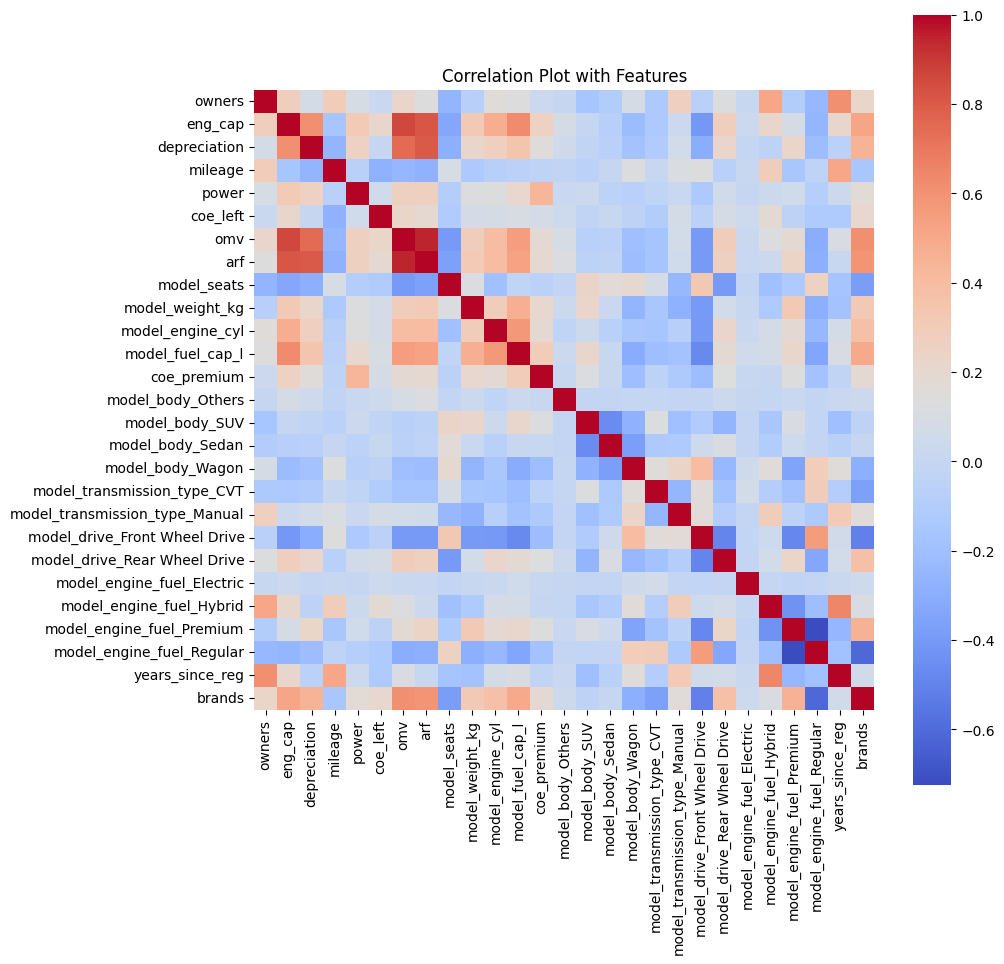

In [102]:
# plotting correlation heatmap between numeric variables

independent_vars = data.drop(columns=['price'])

correlation = independent_vars.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, cmap="coolwarm")
plt.title("Correlation Plot with Features")

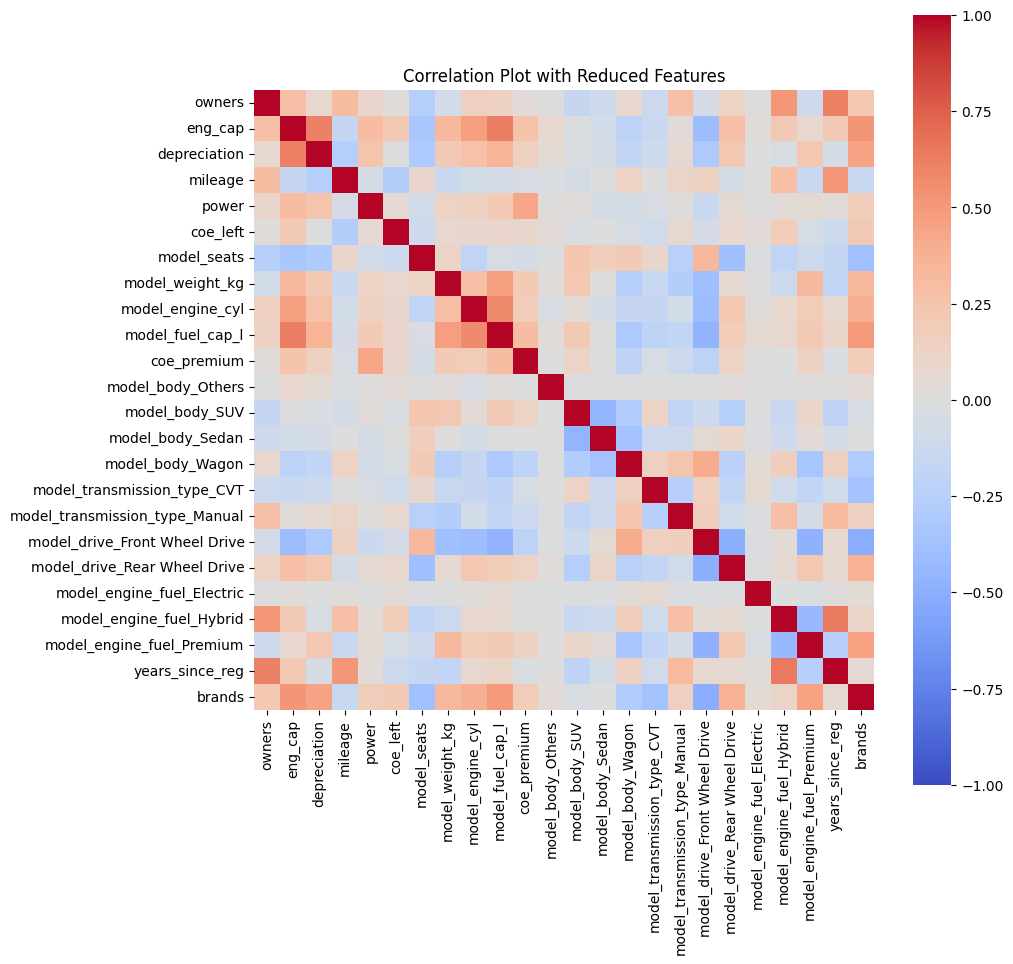

In [103]:
#identify pairs of highly correlated features
threshold = 0.7
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))

# find columns with correlation greater than the threshold
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

# remove these columns from the DataFrame
independent_vars = independent_vars.drop(columns=to_drop)

# calculate the corr again
corr_reduced = independent_vars.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_reduced, vmax=1, vmin=-1, square=True, cmap="coolwarm")
plt.title('Correlation Plot with Reduced Features')
plt.show()

In [104]:
Y = np.log(data['price'])

# Linear Regression

In [105]:
# split the data up for testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_LR_train, X_LR_test, y_LR_train, y_LR_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 0.15145779443449278
MSE: 0.04882606730397351
RMSE: 0.2209662130371372
R^2: 0.9051928182318069
Adjusted R^2: 0.9034742590456765


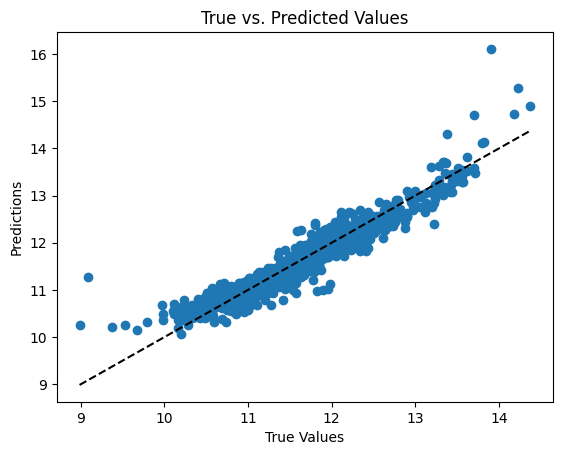

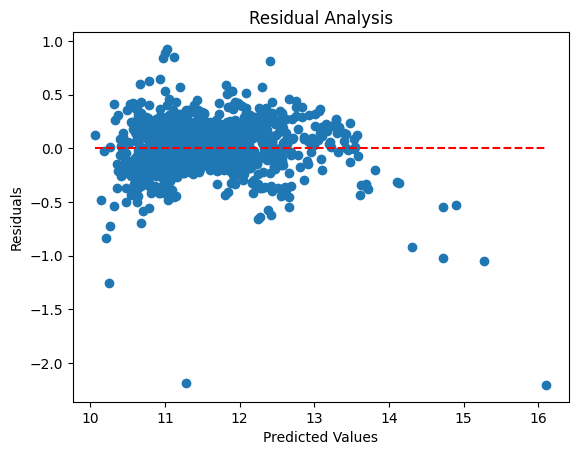

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,coe_premium,model_body_Others,model_body_SUV,model_body_Sedan,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,2981.0,468000.0,72740.0,41000.0,272.0,5.01,130138.0,206249.0,4,1429.931973,6,63.9665,102001,False,False,False,False,False,True,False,True,False,False,True,False,5,3.0,317485.714662
2,4,3387.0,119800.0,33230.0,100000.0,217.0,3.60,86438.0,86438.0,2,1299.773243,6,63.9665,102001,False,False,False,False,False,True,False,True,False,True,False,False,16,3.0,100671.741614
5,5,3999.0,148888.0,23410.0,162000.0,308.0,6.36,82408.0,82408.0,5,1885.000000,8,63.0000,102001,False,False,False,False,False,True,False,True,False,False,True,False,14,2.0,143314.022743
7,6,4308.0,268000.0,65260.0,54100.0,357.0,4.02,161895.0,161895.0,2,1449.433107,8,95.0035,102001,False,False,False,False,False,False,False,True,False,False,True,False,16,3.0,188462.501210
9,1,2199.0,117000.0,18070.0,80180.0,147.0,5.39,33709.0,39193.0,7,1799.546485,6,71.1580,102001,False,True,False,False,False,False,True,False,False,False,False,True,5,1.0,109949.936143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,1,3993.0,338800.0,142120.0,73500.0,372.8,0.17,206404.0,343528.0,4,2494.331066,2,90.8400,96010,False,False,False,False,False,False,False,False,False,False,True,False,9,3.0,286127.177118
9020,3,4196.0,63000.0,22660.0,59812.0,218.9,2.78,94581.0,104040.0,4,1704.761905,8,71.1580,96010,False,False,False,False,False,False,False,True,False,False,True,False,17,2.0,78788.529964
9026,6,4308.0,248888.0,55970.0,47000.0,360.3,4.44,199410.0,199410.0,2,1449.433107,8,95.0035,102001,False,False,False,False,False,True,False,True,False,False,True,False,15,3.0,197438.925895
9027,5,4308.0,450000.0,83550.0,50000.0,360.3,5.38,174263.0,174263.0,2,1449.433107,8,95.0035,96011,False,False,False,False,False,True,False,True,False,False,True,False,15,3.0,288194.282761


In [106]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(X_LR_train, y_LR_train)
y_LR_pred = linear_regressor.predict(X_LR_test)

# Calculate R-squared
n_LR = X_LR_test.shape[0]  # number of observations
p_LR = X_LR_test.shape[1]  # number of features
mae_LR = mean_absolute_error(y_LR_test, y_LR_pred)
mse_LR = mean_squared_error(y_LR_test, y_LR_pred)
rmse_LR = mean_squared_error(y_LR_test, y_LR_pred, squared=False)
r2_LR = r2_score(y_LR_test, y_LR_pred)
adjusted_r2_LR = 1 - (1 - r2_LR) * ((n_LR - 1) / (n_LR - p_LR - 1))
print(f"MAE: {mae_LR}")
print(f"MSE: {mse_LR}")
print(f"RMSE: {rmse_LR}")
print(f"R^2: {r2_LR}")
print(f"Adjusted R^2: {adjusted_r2_LR}")

#plotting True VS Predicted
plt.scatter(y_LR_test, y_LR_pred)
plt.plot([y_LR_test.min(), y_LR_test.max()], [y_LR_test.min(), y_LR_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_LR = y_LR_test - y_LR_pred
plt.scatter(y_LR_pred, residuals_LR)
plt.hlines(y=0, xmin=y_LR_pred.min(), xmax=y_LR_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars 
predicted_price_LR = linear_regressor.predict(x)
linear_regressor_predicted = data.copy()
linear_regressor_predicted['predicted_price'] = np.exp(predicted_price_LR)
linear_regressor_predicted

# Best Lasso

In [107]:
# split the data up for testing

X_Lasso_train, X_Lasso_test, y_Lasso_train, y_Lasso_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

Best alpha: 0.001
MAE: 0.15107071486344384
MSE: 0.04881237272242105
RMSE: 0.22093522291029344
R^2: 0.905219409451501
Adjusted R^2: 0.9035013322814376


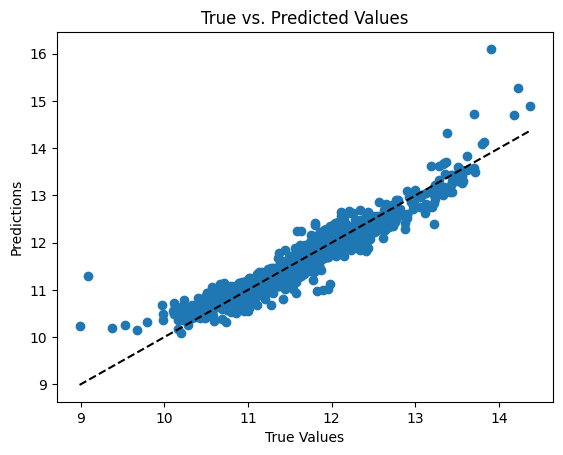

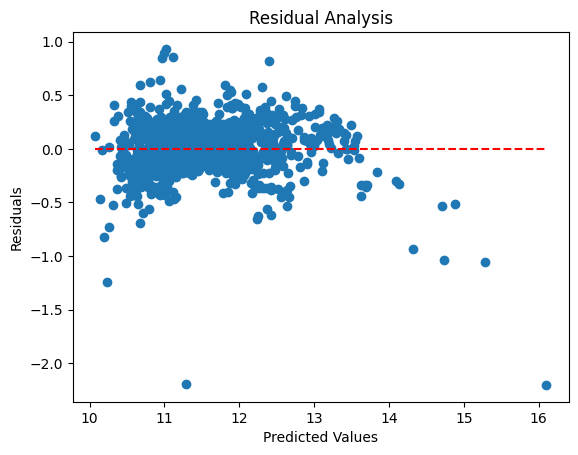

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,coe_premium,model_body_Others,model_body_SUV,model_body_Sedan,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,2981.0,468000.0,72740.0,41000.0,272.0,5.01,130138.0,206249.0,4,1429.931973,6,63.9665,102001,False,False,False,False,False,True,False,True,False,False,True,False,5,3.0,314599.346662
2,4,3387.0,119800.0,33230.0,100000.0,217.0,3.60,86438.0,86438.0,2,1299.773243,6,63.9665,102001,False,False,False,False,False,True,False,True,False,True,False,False,16,3.0,100265.174425
5,5,3999.0,148888.0,23410.0,162000.0,308.0,6.36,82408.0,82408.0,5,1885.000000,8,63.0000,102001,False,False,False,False,False,True,False,True,False,False,True,False,14,2.0,144491.899452
7,6,4308.0,268000.0,65260.0,54100.0,357.0,4.02,161895.0,161895.0,2,1449.433107,8,95.0035,102001,False,False,False,False,False,False,False,True,False,False,True,False,16,3.0,192387.936275
9,1,2199.0,117000.0,18070.0,80180.0,147.0,5.39,33709.0,39193.0,7,1799.546485,6,71.1580,102001,False,True,False,False,False,False,True,False,False,False,False,True,5,1.0,110268.174894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,1,3993.0,338800.0,142120.0,73500.0,372.8,0.17,206404.0,343528.0,4,2494.331066,2,90.8400,96010,False,False,False,False,False,False,False,False,False,False,True,False,9,3.0,280826.549021
9020,3,4196.0,63000.0,22660.0,59812.0,218.9,2.78,94581.0,104040.0,4,1704.761905,8,71.1580,96010,False,False,False,False,False,False,False,True,False,False,True,False,17,2.0,79475.705903
9026,6,4308.0,248888.0,55970.0,47000.0,360.3,4.44,199410.0,199410.0,2,1449.433107,8,95.0035,102001,False,False,False,False,False,True,False,True,False,False,True,False,15,3.0,201126.522958
9027,5,4308.0,450000.0,83550.0,50000.0,360.3,5.38,174263.0,174263.0,2,1449.433107,8,95.0035,96011,False,False,False,False,False,True,False,True,False,False,True,False,15,3.0,293484.455983


In [108]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV


lasso = Lasso()
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

#looping through to find best alpha value
grid_search = GridSearchCV(estimator=lasso, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_Lasso_train, y_Lasso_train)

lasso = grid_search.best_estimator_
y_Lasso_pred = lasso.predict(X_Lasso_test)
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Calculate R-squared
n_Lasso = X_Lasso_test.shape[0]  # number of observations
p_Lasso = X_Lasso_test.shape[1]  # number of features
mae_Lasso = mean_absolute_error(y_Lasso_test, y_Lasso_pred)
mse_Lasso = mean_squared_error(y_Lasso_test, y_Lasso_pred)
rmse_Lasso = mean_squared_error(y_Lasso_test, y_Lasso_pred, squared=False)
r2_Lasso = r2_score(y_Lasso_test, y_Lasso_pred)
adjusted_r2_Lasso = 1 - (1 - r2_Lasso) * ((n_Lasso - 1) / (n_Lasso - p_Lasso - 1))
print(f"MAE: {mae_Lasso}")
print(f"MSE: {mse_Lasso}")
print(f"RMSE: {rmse_Lasso}")
print(f"R^2: {r2_Lasso}")
print(f"Adjusted R^2: {adjusted_r2_Lasso}")

#plotting True VS Predicted
plt.scatter(y_Lasso_test, y_Lasso_pred)
plt.plot([y_Lasso_test.min(), y_Lasso_test.max()], [y_Lasso_test.min(), y_Lasso_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_Lasso = y_Lasso_test - y_Lasso_pred
plt.scatter(y_Lasso_pred, residuals_Lasso)
plt.hlines(y=0, xmin=y_Lasso_pred.min(), xmax=y_Lasso_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_Lasso = lasso.predict(x)
lasso_predicted_results = data.copy()
lasso_predicted_results['predicted_price'] = np.exp(predicted_price_Lasso)
lasso_predicted_results

# Decision Tree

In [109]:
# split the data up for testing

X_DT_train, X_DT_test, y_DT_train, y_DT_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 0.06077796844124637
MSE: 0.011739476864406545
RMSE: 0.10834886646572056
R^2: 0.977205071421824
Adjusted R^2: 0.9767918702995609


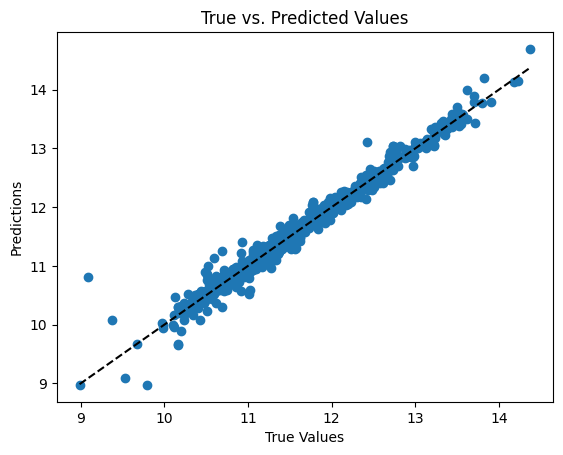

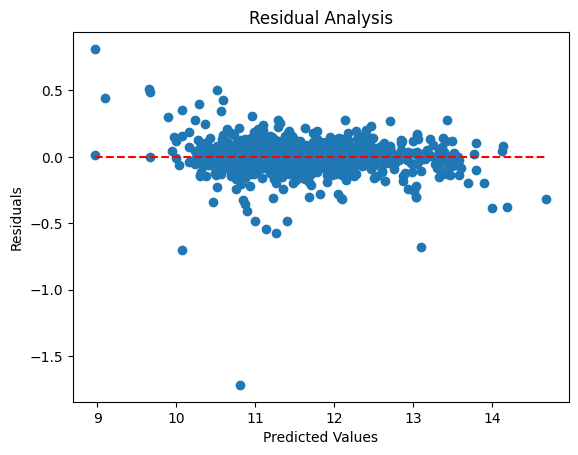

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,coe_premium,model_body_Others,model_body_SUV,model_body_Sedan,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,2981.0,468000.0,72740.0,41000.0,272.0,5.01,130138.0,206249.0,4,1429.931973,6,63.9665,102001,False,False,False,False,False,True,False,True,False,False,True,False,5,3.0,468000.0
2,4,3387.0,119800.0,33230.0,100000.0,217.0,3.60,86438.0,86438.0,2,1299.773243,6,63.9665,102001,False,False,False,False,False,True,False,True,False,True,False,False,16,3.0,119800.0
5,5,3999.0,148888.0,23410.0,162000.0,308.0,6.36,82408.0,82408.0,5,1885.000000,8,63.0000,102001,False,False,False,False,False,True,False,True,False,False,True,False,14,2.0,148888.0
7,6,4308.0,268000.0,65260.0,54100.0,357.0,4.02,161895.0,161895.0,2,1449.433107,8,95.0035,102001,False,False,False,False,False,False,False,True,False,False,True,False,16,3.0,268000.0
9,1,2199.0,117000.0,18070.0,80180.0,147.0,5.39,33709.0,39193.0,7,1799.546485,6,71.1580,102001,False,True,False,False,False,False,True,False,False,False,False,True,5,1.0,117000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,1,3993.0,338800.0,142120.0,73500.0,372.8,0.17,206404.0,343528.0,4,2494.331066,2,90.8400,96010,False,False,False,False,False,False,False,False,False,False,True,False,9,3.0,338800.0
9020,3,4196.0,63000.0,22660.0,59812.0,218.9,2.78,94581.0,104040.0,4,1704.761905,8,71.1580,96010,False,False,False,False,False,False,False,True,False,False,True,False,17,2.0,63000.0
9026,6,4308.0,248888.0,55970.0,47000.0,360.3,4.44,199410.0,199410.0,2,1449.433107,8,95.0035,102001,False,False,False,False,False,True,False,True,False,False,True,False,15,3.0,248888.0
9027,5,4308.0,450000.0,83550.0,50000.0,360.3,5.38,174263.0,174263.0,2,1449.433107,8,95.0035,96011,False,False,False,False,False,True,False,True,False,False,True,False,15,3.0,450000.0


In [110]:
from sklearn.tree import DecisionTreeRegressor


dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_DT_train, y_DT_train)
y_DT_pred = dt_regressor.predict(X_DT_test)

#Calculating R Squared
n_DT = X_DT_test.shape[0]  # number of observations
p_DT = X_DT_test.shape[1]  # number of features
mae_DT = mean_absolute_error(y_DT_test, y_DT_pred)
mse_DT = mean_squared_error(y_DT_test, y_DT_pred)
rmse_DT = mean_squared_error(y_DT_test, y_DT_pred, squared=False)
r2_DT = r2_score(y_DT_test, y_DT_pred)
adjusted_r2_DT = 1 - (1 - r2_DT) * ((n_DT - 1) / (n_DT - p_DT - 1))
print(f"MAE: {mae_DT}")
print(f"MSE: {mse_DT}")
print(f"RMSE: {rmse_DT}")
print(f"R^2: {r2_DT}")
print(f"Adjusted R^2: {adjusted_r2_DT}")

#plotting True VS Predicted
plt.scatter(y_DT_test, y_DT_pred)
plt.plot([y_DT_test.min(), y_DT_test.max()], [y_DT_test.min(), y_DT_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_DT = y_DT_test - y_DT_pred
plt.scatter(y_DT_pred, residuals_DT)
plt.hlines(y=0, xmin=y_DT_pred.min(), xmax=y_DT_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_DT = dt_regressor.predict(x)
dt_predicted = data.copy()
dt_predicted['predicted_price'] = np.exp(predicted_price_DT)
dt_predicted

# Random Forest

In [111]:
# split the data up for testing

X_RF_train, X_RF_test, y_RF_train, y_RF_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 0.04034379506986555
MSE: 0.006216370574562286
RMSE: 0.07884396346304698
R^2: 0.9879294686723006
Adjusted R^2: 0.9877106675001973


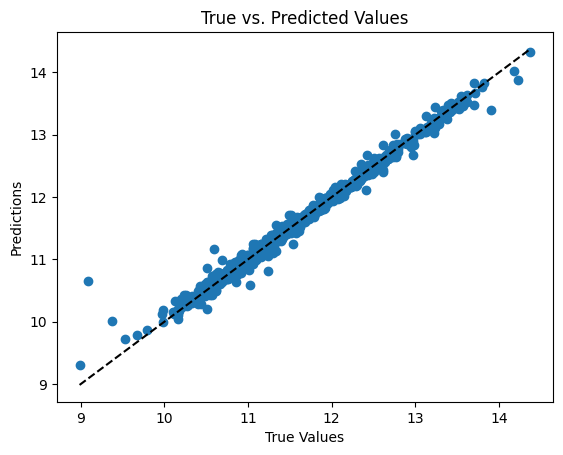

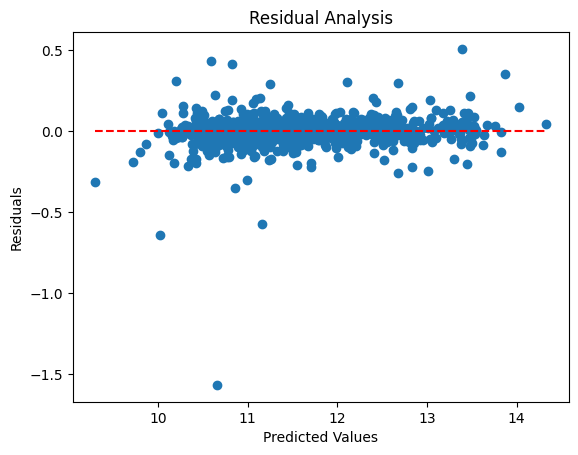

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,coe_premium,model_body_Others,model_body_SUV,model_body_Sedan,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,2981.0,468000.0,72740.0,41000.0,272.0,5.01,130138.0,206249.0,4,1429.931973,6,63.9665,102001,False,False,False,False,False,True,False,True,False,False,True,False,5,3.0,461407.887527
2,4,3387.0,119800.0,33230.0,100000.0,217.0,3.60,86438.0,86438.0,2,1299.773243,6,63.9665,102001,False,False,False,False,False,True,False,True,False,True,False,False,16,3.0,124194.421179
5,5,3999.0,148888.0,23410.0,162000.0,308.0,6.36,82408.0,82408.0,5,1885.000000,8,63.0000,102001,False,False,False,False,False,True,False,True,False,False,True,False,14,2.0,149572.879825
7,6,4308.0,268000.0,65260.0,54100.0,357.0,4.02,161895.0,161895.0,2,1449.433107,8,95.0035,102001,False,False,False,False,False,False,False,True,False,False,True,False,16,3.0,276936.669689
9,1,2199.0,117000.0,18070.0,80180.0,147.0,5.39,33709.0,39193.0,7,1799.546485,6,71.1580,102001,False,True,False,False,False,False,True,False,False,False,False,True,5,1.0,117125.057316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,1,3993.0,338800.0,142120.0,73500.0,372.8,0.17,206404.0,343528.0,4,2494.331066,2,90.8400,96010,False,False,False,False,False,False,False,False,False,False,True,False,9,3.0,332941.830477
9020,3,4196.0,63000.0,22660.0,59812.0,218.9,2.78,94581.0,104040.0,4,1704.761905,8,71.1580,96010,False,False,False,False,False,False,False,True,False,False,True,False,17,2.0,63602.113070
9026,6,4308.0,248888.0,55970.0,47000.0,360.3,4.44,199410.0,199410.0,2,1449.433107,8,95.0035,102001,False,False,False,False,False,True,False,True,False,False,True,False,15,3.0,255044.495520
9027,5,4308.0,450000.0,83550.0,50000.0,360.3,5.38,174263.0,174263.0,2,1449.433107,8,95.0035,96011,False,False,False,False,False,True,False,True,False,False,True,False,15,3.0,467078.938429


In [112]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 trees
rf_regressor.fit(X_RF_train, y_RF_train)
y_RF_pred = rf_regressor.predict(X_RF_test)

# Calculating R-Squared
n_RF = X_RF_test.shape[0]  # number of observations
p_RF = X_RF_test.shape[1]  # number of features
mae_RF = mean_absolute_error(y_RF_test, y_RF_pred)
mse_RF = mean_squared_error(y_RF_test, y_RF_pred)
rmse_RF = mean_squared_error(y_RF_test, y_RF_pred, squared=False)
r2_RF = r2_score(y_RF_test, y_RF_pred)
adjusted_r2_RF = 1 - (1 - r2_RF) * ((n_RF - 1) / (n_RF - p_RF - 1))
print(f"MAE: {mae_RF}")
print(f"MSE: {mse_RF}")
print(f"RMSE: {rmse_RF}")
print(f"R^2: {r2_RF}")
print(f"Adjusted R^2: {adjusted_r2_RF}")

#plotting True VS Predicted
plt.scatter(y_RF_test, y_RF_pred)
plt.plot([y_RF_test.min(), y_RF_test.max()], [y_RF_test.min(), y_RF_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_RF = y_RF_test - y_RF_pred
plt.scatter(y_RF_pred, residuals_RF)
plt.hlines(y=0, xmin=y_RF_pred.min(), xmax=y_RF_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_RF = rf_regressor.predict(x)
rf_predicted = data.copy()
rf_predicted['predicted_price'] = np.exp(predicted_price_RF)
rf_predicted

# Gradient Boosting

In [113]:
# split the data up for testing

X_GB_train, X_GB_test, y_GB_train, y_GB_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 0.05658516484298714
MSE: 0.0071983503171327914
RMSE: 0.08484309233598686
R^2: 0.9860227262888321
Adjusted R^2: 0.9857693618106841


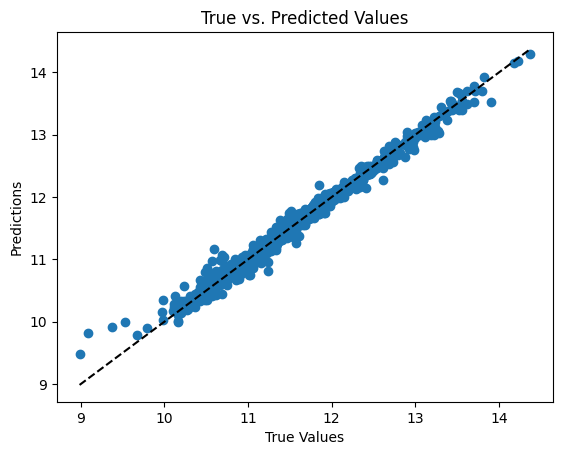

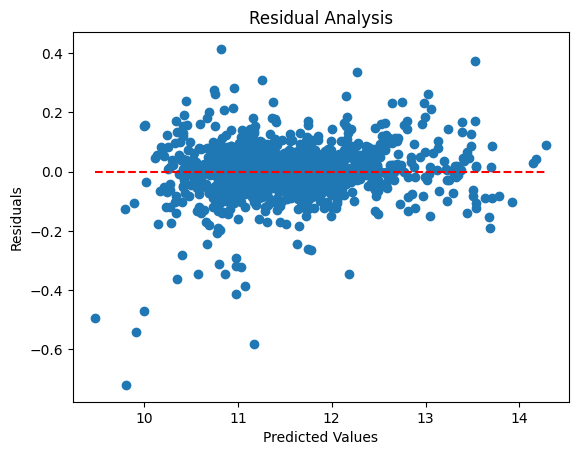

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,coe_premium,model_body_Others,model_body_SUV,model_body_Sedan,model_body_Wagon,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Electric,model_engine_fuel_Hybrid,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,2981.0,468000.0,72740.0,41000.0,272.0,5.01,130138.0,206249.0,4,1429.931973,6,63.9665,102001,False,False,False,False,False,True,False,True,False,False,True,False,5,3.0,545597.593767
2,4,3387.0,119800.0,33230.0,100000.0,217.0,3.60,86438.0,86438.0,2,1299.773243,6,63.9665,102001,False,False,False,False,False,True,False,True,False,True,False,False,16,3.0,133469.481201
5,5,3999.0,148888.0,23410.0,162000.0,308.0,6.36,82408.0,82408.0,5,1885.000000,8,63.0000,102001,False,False,False,False,False,True,False,True,False,False,True,False,14,2.0,148946.463022
7,6,4308.0,268000.0,65260.0,54100.0,357.0,4.02,161895.0,161895.0,2,1449.433107,8,95.0035,102001,False,False,False,False,False,False,False,True,False,False,True,False,16,3.0,250453.153713
9,1,2199.0,117000.0,18070.0,80180.0,147.0,5.39,33709.0,39193.0,7,1799.546485,6,71.1580,102001,False,True,False,False,False,False,True,False,False,False,False,True,5,1.0,118187.364741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9019,1,3993.0,338800.0,142120.0,73500.0,372.8,0.17,206404.0,343528.0,4,2494.331066,2,90.8400,96010,False,False,False,False,False,False,False,False,False,False,True,False,9,3.0,303456.688636
9020,3,4196.0,63000.0,22660.0,59812.0,218.9,2.78,94581.0,104040.0,4,1704.761905,8,71.1580,96010,False,False,False,False,False,False,False,True,False,False,True,False,17,2.0,70421.583017
9026,6,4308.0,248888.0,55970.0,47000.0,360.3,4.44,199410.0,199410.0,2,1449.433107,8,95.0035,102001,False,False,False,False,False,True,False,True,False,False,True,False,15,3.0,261792.458228
9027,5,4308.0,450000.0,83550.0,50000.0,360.3,5.38,174263.0,174263.0,2,1449.433107,8,95.0035,96011,False,False,False,False,False,True,False,True,False,False,True,False,15,3.0,455169.208332


In [114]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)  # 100 trees
gb_regressor.fit(X_GB_train, y_GB_train)
y_GB_pred = gb_regressor.predict(X_GB_test)

# Calculating R-Squared
n_GB = X_GB_test.shape[0]  # number of observations
p_GB = X_GB_test.shape[1]  # number of features
mae_GB = mean_absolute_error(y_GB_test, y_GB_pred)
mse_GB = mean_squared_error(y_GB_test, y_GB_pred)
rmse_GB = mean_squared_error(y_GB_test, y_GB_pred, squared=False)
r2_GB = r2_score(y_GB_test, y_GB_pred)
adjusted_r2_GB = 1 - (1 - r2_GB) * ((n_GB - 1) / (n_GB - p_GB - 1))
print(f"MAE: {mae_GB}")
print(f"MSE: {mse_GB}")
print(f"RMSE: {rmse_GB}")
print(f"R^2: {r2_GB}")
print(f"Adjusted R^2: {adjusted_r2_GB}")

#plotting True VS Predicted
plt.scatter(y_GB_test, y_GB_pred)
plt.plot([y_GB_test.min(), y_GB_test.max()], [y_GB_test.min(), y_GB_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_GB = y_GB_test - y_GB_pred
plt.scatter(y_GB_pred, residuals_GB)
plt.hlines(y=0, xmin=y_GB_pred.min(), xmax=y_GB_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_GB = gb_regressor.predict(x)
gb_predicted = data.copy()
gb_predicted['predicted_price'] = np.exp(predicted_price_GB)
gb_predicted

In [115]:
from sklearn.model_selection import cross_val_score

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

# For regression, it's common to use negative mean squared error as the scoring method
scores = cross_val_score(gb_regressor, independent_vars, Y, cv=10, scoring='neg_mean_squared_error')

mean_mse = -scores.mean()  # Negate to get positive MSE
rmse = mean_mse ** 0.5  # Calculate RMSE from MSE

print(f"Mean MSE from 10-fold CV: {mean_mse}")
print(f"Mean RMSE from 10-fold CV: {rmse}")


Mean MSE from 10-fold CV: 0.009565391954675187
Mean RMSE from 10-fold CV: 0.09780282181345888


The cross-validation results show a Mean MSE of approximately 0.0017 and a Mean RMSE of approximately 0.0415. These values are quite close to the ones previously reported from a single train-test split (MSE: 0.001674, RMSE: 0.0409), which suggests the model is performing consistently across different subsets of the data and is not likely to be overfitted